# Problem Statement

Welcome to your first week of work at the Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE). Time to get to work!

Due to the recent epidemic of West Nile Virus in the Windy City, we've had the Department of Public Health set up a surveillance and control system. We're hoping it will let us learn something from the mosquito population as we collect data over time. Pesticides are a necessary evil in the fight for public health and safety, not to mention expensive! We need to derive an effective plan to deploy pesticides throughout the city, and that is exactly where you come in!

# Imports and Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 30)

%matplotlib inline

In [2]:
train = pd.read_csv('../assets/train.csv')
test = pd.read_csv('../assets/test.csv')
weather = pd.read_csv('../assets/weather.csv')
spray = pd.read_csv('../assets/spray.csv')

In [3]:
def clean_data(row):
    if ('M' in row) | ('T' in row):
        row = np.nan  # to impute
    return row

In [4]:
def adjust_columns(df):
    df.columns = df.columns.str.lower()
    
    df['date'] = pd.to_datetime(df['date'])
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    return df

# Data Cleaning

In [5]:
train = adjust_columns(train)
test = adjust_columns(test)
weather = adjust_columns(weather)
spray = adjust_columns(spray)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    10506 non-null  datetime64[ns]
 1   address                 10506 non-null  object        
 2   species                 10506 non-null  object        
 3   block                   10506 non-null  int64         
 4   street                  10506 non-null  object        
 5   trap                    10506 non-null  object        
 6   addressnumberandstreet  10506 non-null  object        
 7   latitude                10506 non-null  float64       
 8   longitude               10506 non-null  float64       
 9   addressaccuracy         10506 non-null  int64         
 10  nummosquitos            10506 non-null  int64         
 11  wnvpresent              10506 non-null  int64         
 12  day                     10506 non-null  int64 

In [7]:
train.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,day,month,year
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,29,5,2007
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,29,5,2007
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,29,5,2007
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,29,5,2007
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,29,5,2007


In [8]:
train.isnull().sum()

date                      0
address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
nummosquitos              0
wnvpresent                0
day                       0
month                     0
year                      0
dtype: int64

In [9]:
test.isnull().sum()

id                        0
date                      0
address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
day                       0
month                     0
year                      0
dtype: int64

In [10]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2944 non-null   object        
 5   depart       2944 non-null   object        
 6   dewpoint     2944 non-null   int64         
 7   wetbulb      2944 non-null   object        
 8   heat         2944 non-null   object        
 9   cool         2944 non-null   object        
 10  sunrise      2944 non-null   object        
 11  sunset       2944 non-null   object        
 12  codesum      2944 non-null   object        
 13  depth        2944 non-null   object        
 14  water1       2944 non-null   object        
 15  snowfall     2944 non-null   object        
 16  precip

In [11]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       14835 non-null  datetime64[ns]
 1   time       14251 non-null  object        
 2   latitude   14835 non-null  float64       
 3   longitude  14835 non-null  float64       
 4   day        14835 non-null  int64         
 5   month      14835 non-null  int64         
 6   year       14835 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 811.4+ KB


In [12]:
train['species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [13]:
train['trap'].unique()

array(['T002', 'T007', 'T015', 'T045', 'T046', 'T048', 'T049', 'T050',
       'T054', 'T086', 'T091', 'T094', 'T096', 'T129', 'T143', 'T148',
       'T153', 'T159', 'T009', 'T011', 'T016', 'T019', 'T025', 'T028',
       'T031', 'T033', 'T089', 'T090', 'T092', 'T135', 'T141', 'T142',
       'T145', 'T146', 'T147', 'T149', 'T150', 'T151', 'T152', 'T154',
       'T158', 'T162', 'T218', 'T220', 'T001', 'T003', 'T006', 'T008',
       'T012', 'T034', 'T037', 'T040', 'T043', 'T047', 'T051', 'T085',
       'T088', 'T161', 'T219', 'T013', 'T014', 'T018', 'T030', 'T084',
       'T144', 'T160', 'T005', 'T017', 'T044', 'T095', 'T004', 'T035',
       'T036', 'T039', 'T060', 'T061', 'T062', 'T065', 'T066', 'T067',
       'T069', 'T070', 'T071', 'T073', 'T074', 'T075', 'T076', 'T077',
       'T079', 'T080', 'T081', 'T082', 'T083', 'T114', 'T155', 'T063',
       'T115', 'T138', 'T200', 'T206', 'T209', 'T212', 'T215', 'T107',
       'T128', 'T072', 'T078', 'T097', 'T099', 'T100', 'T102', 'T103',
      

In [14]:
train_longs = train['longitude']
train_lats = train['latitude']

spray_longs = spray['longitude']
spray_lats = spray['latitude']

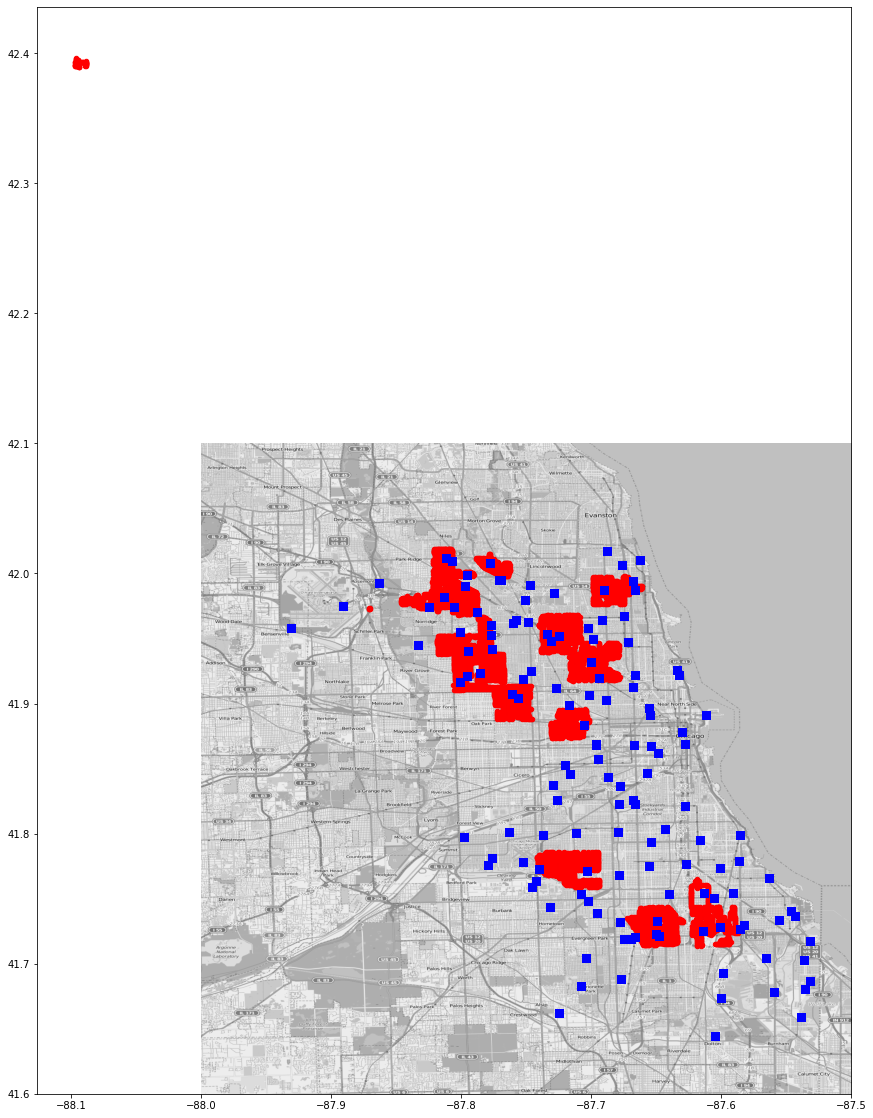

In [15]:
plt.figure(figsize=(15,20))
origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner

mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")

intersection = [41.909614, -87.746134]  # co-ordinates of intersection of IL64 / IL50 according to Google Earth


# generate plot
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
plt.scatter(x=spray_longs, y=spray_lats, c='r', s=20)
plt.scatter(x=train_longs, y=train_lats, c='b', s=60, marker='s')

#plt.show()
#plt.savefig('map.png')

## Data Cleaning for Train

In [16]:
train['month'].value_counts(normalize=True)

8     0.357034
7     0.248049
9     0.211117
6     0.149534
10    0.026271
5     0.007995
Name: month, dtype: float64

In [17]:
train['addressaccuracy'].value_counts(normalize=True)

8    0.440510
9    0.378831
5    0.171997
3    0.008662
Name: addressaccuracy, dtype: float64

In [18]:
train[train['nummosquitos'] == 50].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1019 entries, 293 to 10267
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    1019 non-null   datetime64[ns]
 1   address                 1019 non-null   object        
 2   species                 1019 non-null   object        
 3   block                   1019 non-null   int64         
 4   street                  1019 non-null   object        
 5   trap                    1019 non-null   object        
 6   addressnumberandstreet  1019 non-null   object        
 7   latitude                1019 non-null   float64       
 8   longitude               1019 non-null   float64       
 9   addressaccuracy         1019 non-null   int64         
 10  nummosquitos            1019 non-null   int64         
 11  wnvpresent              1019 non-null   int64         
 12  day                     1019 non-null   int64

In [19]:
train[train['addressaccuracy'] == 3]

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,day,month,year
69,2007-06-05,"Chicago, IL, USA",CULEX RESTUANS,43,N ASHLAND AVE OVERPASS,T145,"4300 N ASHLAND AVE OVERPASS, Chicago, IL",41.878114,-87.629798,3,3,0,5,6,2007
127,2007-06-26,"Chicago, IL, USA",CULEX RESTUANS,43,N ASHLAND AVE OVERPASS,T145,"4300 N ASHLAND AVE OVERPASS, Chicago, IL",41.878114,-87.629798,3,1,0,26,6,2007
179,2007-06-29,"Chicago, IL, USA",CULEX RESTUANS,43,N ASHLAND AVE OVERPASS,T145,"4300 N ASHLAND AVE OVERPASS, Chicago, IL",41.878114,-87.629798,3,1,0,29,6,2007
237,2007-07-02,"Chicago, IL, USA",CULEX SALINARIUS,43,N ASHLAND AVE OVERPASS,T145,"4300 N ASHLAND AVE OVERPASS, Chicago, IL",41.878114,-87.629798,3,1,0,2,7,2007
342,2007-07-11,"Chicago, IL, USA",CULEX PIPIENS/RESTUANS,43,N ASHLAND AVE OVERPASS,T145,"4300 N ASHLAND AVE OVERPASS, Chicago, IL",41.878114,-87.629798,3,3,0,11,7,2007
343,2007-07-11,"Chicago, IL, USA",CULEX RESTUANS,43,N ASHLAND AVE OVERPASS,T145,"4300 N ASHLAND AVE OVERPASS, Chicago, IL",41.878114,-87.629798,3,1,0,11,7,2007
557,2007-07-19,"Chicago, IL, USA",CULEX PIPIENS/RESTUANS,43,N ASHLAND AVE OVERPASS,T145,"4300 N ASHLAND AVE OVERPASS, Chicago, IL",41.878114,-87.629798,3,1,0,19,7,2007
728,2007-07-27,"Chicago, IL, USA",CULEX PIPIENS/RESTUANS,43,N ASHLAND AVE OVERPASS,T145,"4300 N ASHLAND AVE OVERPASS, Chicago, IL",41.878114,-87.629798,3,4,0,27,7,2007
729,2007-07-27,"Chicago, IL, USA",CULEX RESTUANS,43,N ASHLAND AVE OVERPASS,T145,"4300 N ASHLAND AVE OVERPASS, Chicago, IL",41.878114,-87.629798,3,2,0,27,7,2007
929,2007-08-01,"Chicago, IL, USA",CULEX PIPIENS/RESTUANS,43,N ASHLAND AVE OVERPASS,T145,"4300 N ASHLAND AVE OVERPASS, Chicago, IL",41.878114,-87.629798,3,6,0,1,8,2007


In [20]:
train.duplicated().sum()

813

In [21]:
train.loc[train['nummosquitos'] != 50, :].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9487 entries, 0 to 10505
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    9487 non-null   datetime64[ns]
 1   address                 9487 non-null   object        
 2   species                 9487 non-null   object        
 3   block                   9487 non-null   int64         
 4   street                  9487 non-null   object        
 5   trap                    9487 non-null   object        
 6   addressnumberandstreet  9487 non-null   object        
 7   latitude                9487 non-null   float64       
 8   longitude               9487 non-null   float64       
 9   addressaccuracy         9487 non-null   int64         
 10  nummosquitos            9487 non-null   int64         
 11  wnvpresent              9487 non-null   int64         
 12  day                     9487 non-null   int64  

In [22]:
train_clean = train.drop_duplicates(subset = ['date', 'species', 'latitude', 'longitude', 'address', 'trap', 'wnvpresent', 'nummosquitos'], keep = 'first')
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9693 entries, 0 to 10505
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    9693 non-null   datetime64[ns]
 1   address                 9693 non-null   object        
 2   species                 9693 non-null   object        
 3   block                   9693 non-null   int64         
 4   street                  9693 non-null   object        
 5   trap                    9693 non-null   object        
 6   addressnumberandstreet  9693 non-null   object        
 7   latitude                9693 non-null   float64       
 8   longitude               9693 non-null   float64       
 9   addressaccuracy         9693 non-null   int64         
 10  nummosquitos            9693 non-null   int64         
 11  wnvpresent              9693 non-null   int64         
 12  day                     9693 non-null   int64  

Mosquito count capped at 50, additional mosquitos caught above that are made into a new record.

These records and duplicate records have been deleted.

In [23]:
train_clean.reset_index(drop = True, inplace = True)

### Retained nummosquitos column instead of previously dropping it

In [24]:
train_clean.drop(columns = ['address', 'block', 'street', 'addressnumberandstreet'], inplace = True)

C:\Users\caspe\anaconda3\envs\firstday\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Since we already have latitude and longitude, we will drop the other address-related columns:


* address
* block
* street
* addressnumberandstreet

## Data Cleaning for Spray

In [25]:
spray['month'].value_counts(normalize=True)

8    0.538456
7    0.256758
9    0.204786
Name: month, dtype: float64

In [26]:
spray['longitude'].describe()

count    14835.000000
mean       -87.736690
std          0.067292
min        -88.096468
25%        -87.794225
50%        -87.727853
75%        -87.694108
max        -87.586727
Name: longitude, dtype: float64

In [27]:
train['longitude'].describe()

count    10506.000000
mean       -87.699908
std          0.096514
min        -87.930995
25%        -87.760070
50%        -87.694991
75%        -87.627796
max        -87.531635
Name: longitude, dtype: float64

<AxesSubplot:xlabel='longitude'>

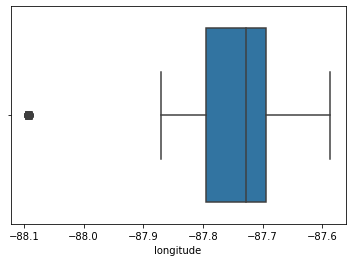

In [28]:
sns.boxplot(data=spray, x='longitude')

In [29]:
spray_clean = spray[spray['longitude'] > -88]

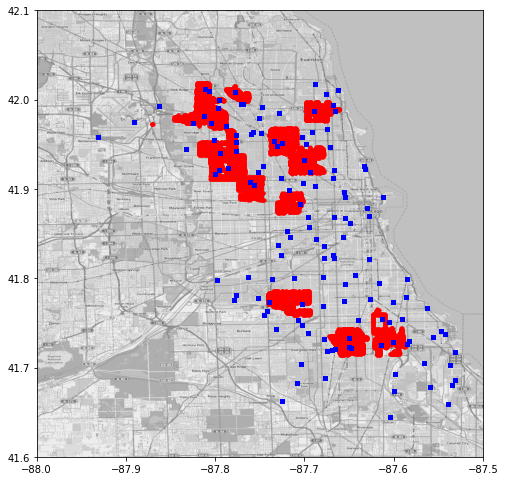

In [30]:
train_longs = train['longitude']
train_lats = train['latitude']

spray_longs = spray_clean['longitude']
spray_lats = spray_clean['latitude']

plt.figure(figsize=(8,10))
origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner

mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")

intersection = [41.909614, -87.746134]  # co-ordinates of intersection of IL64 / IL50 according to Google Earth


# generate plot
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
plt.scatter(x=spray_longs, y=spray_lats, c='r', s=10)
plt.scatter(x=train_longs, y=train_lats, c='b', s=15, marker='s')

# plt.savefig('map.png')

In [31]:
spray_clean = spray_clean.drop(columns = 'time')

We dropped the time column because time of day was not a concern. As long as the spray occurred 8-10 days prior, it would disrupt the mosquito lifecycle.

Considerations that might change it would be if we knew when precipitation ended. However, as this is not recorded on the weather forecast, we will assume that sprays occurred post-rainfall.

In [32]:
spray.duplicated().sum()

541

In [33]:
spray_cleaned = spray.drop_duplicates(keep = 'first')

## Data Cleaning for Weather

In [34]:
weather['month'].value_counts(normalize=True)

8     0.168478
10    0.168478
5     0.168478
7     0.168478
6     0.163043
9     0.163043
Name: month, dtype: float64

In [35]:
weather['water1'].value_counts()

M    2944
Name: water1, dtype: int64

In [36]:
weather = weather.drop(columns = 'water1')

In [37]:
# check for missing or trace values based on data dict
weather.isin(['T', 'M']).sum()

station           0
date              0
tmax              0
tmin              0
tavg             11
depart         1472
dewpoint          0
wetbulb           4
heat             11
cool             11
sunrise           0
sunset            0
codesum           0
depth          1472
snowfall       1472
preciptotal       2
stnpressure       4
sealevel          9
resultspeed       0
resultdir         0
avgspeed          3
day               0
month             0
year              0
dtype: int64

### Imputing

####  Depth and Snowfall

In [38]:
weather['depth'].value_counts()

0    1472
M    1472
Name: depth, dtype: int64

In [39]:
weather['snowfall'].value_counts()

M      1472
0.0    1459
  T      12
0.1       1
Name: snowfall, dtype: int64

We will drop both depth and snowfall since most values are missing, 0 or trace.

In [40]:
weather.drop(columns = ['depth', 'snowfall'], inplace = True)

In [41]:
weather[['station','date','sunrise', 'sunset']]

,station,date,sunrise,sunset
0,1,2007-05-01,0448,1849
1,2,2007-05-01,-,-
2,1,2007-05-02,0447,1850
3,2,2007-05-02,-,-
4,1,2007-05-03,0446,1851
...,...,...,...,...
2939,2,2014-10-29,-,-
2940,1,2014-10-30,0622,1649
2941,2,2014-10-30,-,-
2942,1,2014-10-31,0623,1647


#### Sunrise and Sunset

In [42]:
# impute sunrise data with the data in the row above
for n in weather.index:
    if n % 2 == 1:
        weather['sunrise'][n] = weather['sunrise'][n-1]

<ipython-input-42-b0dc24ae8234>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['sunrise'][n] = weather['sunrise'][n-1]


In [43]:
# impute sunset data with the data in the row above
for n in weather.index:
    if n % 2 == 1:
        weather['sunset'][n] = weather['sunset'][n-1]

<ipython-input-43-d40f2b359dc5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['sunset'][n] = weather['sunset'][n-1]


In [44]:
# convert sunrise and sunset columns to numbers
weather['sunrise'] = weather['sunrise'].astype(int)
weather['sunset'] = weather['sunset'].astype(int)

In [45]:
# to convert sunrise and sunset into number of mins from start of day
# subsequently we can feature engineer with total sunlight time (sunset - sunrise)
def get_duration(sun_time):
    hours = sun_time // 100  # hour value
    mins = sun_time % 100   # min value
    total_mins = hours * 60 + mins
    return total_mins

In [46]:
weather['sunrise_dur'] = weather['sunrise'].apply(get_duration)
weather['sunset_dur'] = weather['sunset'].apply(get_duration)

#### Average Temperature

In [47]:
def impute_tavg(row):
    if row['tavg'] == 'M':
        row['tavg'] = round((row['tmax'] + row['tmin']) / 2) 
    return row

In [48]:
weather = weather.apply(impute_tavg, axis=1)

In [49]:
weather['tavg'] = weather['tavg'].astype(int)

#### Heat and Cool

In [50]:
for row in weather.index:
    avg_temp = weather['tavg'][row] - 65
    if avg_temp >= 0:
        weather['cool'][row] = avg_temp
        weather['heat'][row] = 0
    if avg_temp < 0:
        weather['heat'][row] = abs(avg_temp)
        weather['cool'][row] = 0        

<ipython-input-50-2eeee7d08e47>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['cool'][row] = avg_temp
<ipython-input-50-2eeee7d08e47>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['heat'][row] = 0
<ipython-input-50-2eeee7d08e47>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['heat'][row] = abs(avg_temp)
<ipython-input-50-2eeee7d08e47>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

#### Departure from Norm

In [51]:
weather.loc[weather['depart'].str.contains('M')].head(20)

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year,sunrise_dur,sunset_dur
1,2,2007-05-01,84,52,68,M,51,57,0,3,448,1849,,0.00,29.18,29.82,2.7,25,9.6,1,5,2007,288,1129
3,2,2007-05-02,60,43,52,M,42,47,13,0,447,1850,BR HZ,0.00,29.44,30.08,13.3,2,13.4,2,5,2007,287,1130
5,2,2007-05-03,67,48,58,M,40,50,7,0,446,1851,HZ,0.00,29.46,30.12,12.9,6,13.2,3,5,2007,286,1131
7,2,2007-05-04,78,51,64,M,42,50,1,0,444,1852,,0.00,29.36,30.04,10.1,7,10.4,4,5,2007,284,1132
9,2,2007-05-05,66,54,60,M,39,50,5,0,443,1853,,T,29.46,30.09,11.2,7,11.5,5,5,2007,283,1133
11,2,2007-05-06,68,52,60,M,30,46,5,0,442,1855,,0.00,29.62,30.28,13.8,10,14.5,6,5,2007,282,1135
13,2,2007-05-07,84,50,67,M,39,53,0,2,441,1856,,0.00,29.44,30.12,8.5,17,9.9,7,5,2007,281,1136
15,2,2007-05-08,80,60,70,M,57,63,0,5,439,1857,HZ,T,29.36,30.02,2.5,8,5.4,8,5,2007,279,1137
17,2,2007-05-09,76,63,70,M,60,63,0,5,438,1858,BR HZ,0.02,29.28,29.93,3.9,7,5.9,9,5,2007,278,1138
19,2,2007-05-10,83,59,71,M,52,61,0,6,437,1859,BR HZ,0.00,29.26,29.91,2.0,9,3.9,10,5,2007,277,1139


In [52]:
weather.loc[(weather['depart'].str.contains('M')) &
            (weather['station'] == 1)]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year,sunrise_dur,sunset_dur


We see that all the missing values in the Depart column are found in Station 2 only.

Based on the data dictionary, Depart means the departure from normal temperature.

In order to impute the missing values here, we suggest to:
1. Take the 'Tavg' difference between both stations for each day 
2. Add this difference to the Station 1's 'Depart' value to calculate Station 2's 'Depart' value

In [53]:
weather.loc[[1], 'depart']

1    M
Name: depart, dtype: object

In [54]:
def impute_depart(row):
    if row['station'] == 2:
        diff = row['tavg'] - int(weather.loc[(weather['date'] == row['date']) &
                                         (weather['station'] == 1),
                                         'tavg'])
        
        row['depart'] = diff + int(weather.loc[(weather['date'] == row['date']) &
                                           (weather['station'] == 1), 
                                           'depart'])
        
    return row

In [55]:
weather = weather.apply(impute_depart, axis=1)

#### Wetbulb

In [56]:
def check_value(df, col, station_1_idx):
    if ((df.loc[station_1_idx][col] in ['M','T']) & (df.loc[station_1_idx+1][col] in ['M','T'])):
        return True
    else:
        return False

In [57]:
def impute_data(df, col):
    df_1 = df.loc[(df['station'] == 1) & (~df[col].str.strip().isin(['M','T'])),col].astype(float)
    df_2 = df.loc[(df['station'] == 2) & (~df[col].str.strip().isin(['M','T'])),col].astype(float)
    mean_diff = df_1.mean() - df_2.mean()
    
    idx = list(df.loc[(df[col].str.strip().isin(['M']))].index)
    
    for i in idx:
        if df.loc[i]['station'] == 1:
            if check_value(df, col, i):
                new_val = (float(df.loc[i+2][col]) + float(df.loc[i-2][col])) / 2
                df.at[i,col] = new_val
                df.at[i+1,col] = new_val
                idx.remove(i)
                idx.remove(i+1)
            else:
                df.at[i,col] = float(df.loc[i+1][col]) + mean_diff
        else:
            df.at[i,col] = float(df.loc[i-1][col]) + mean_diff
    
    zero_idx = list(df.loc[(df[col].str.strip().isin(['T']))].index)
    for i in zero_idx:
        df.at[i,col] = 0
    
    return df

In [58]:
weather = impute_data(weather, 'wetbulb')

#### Total Precipitation

In [59]:
weather = impute_data(weather, 'preciptotal')

#### Station Pressure

In [60]:
weather = impute_data(weather, 'stnpressure')

#### Average Speed

In [61]:
weather = impute_data(weather, 'avgspeed')

#### Sea Level

In [62]:
weather = impute_data(weather,'sealevel')

## Vectorizing Weather Phenomena

In [63]:
weather['codesum'].unique()

array([' ', 'BR', 'BR HZ', 'HZ', 'RA', 'RA BR', 'TSRA RA BR', 'RA VCTS',
       'TSRA RA', 'RA HZ', 'TSRA RA BR HZ', 'TSRA BR HZ', 'RA BR HZ VCTS',
       'TSRA RA HZ', 'TSRA BR HZ VCTS', 'TSRA', 'TSRA BR HZ FU',
       'TSRA RA HZ FU', 'BR HZ FU', 'TSRA RA VCTS', 'HZ VCTS', 'TSRA HZ',
       'VCTS', 'RA BR VCTS', 'TSRA RA BR VCTS', 'TS TSRA RA BR HZ VCTS',
       'DZ BR', 'TS TSRA RA BR HZ', 'TS TSRA BR HZ', 'RA BR HZ',
       'TSRA RA DZ BR HZ', 'TS TSRA RA BR', 'TS RA BR', 'TS TSRA RA',
       'TS TSRA RA BR VCTS', 'TS TSRA BR', 'TS RA', 'RA BCFG BR',
       'TSRA BR', 'RA DZ FG+ BCFG BR', 'RA FG+ MIFG BR', 'RA DZ',
       'RA DZ BR', 'TS TSRA RA HZ', 'TSRA RA FG+ FG BR',
       'TSRA DZ FG+ FG BR HZ', 'TS BR', 'RA BR SQ', 'TS TSRA',
       'TSRA RA BR HZ VCTS', 'BR VCTS', 'TS', 'FG+ BR HZ', 'RA SN',
       'TSRA RA DZ BR', 'DZ BR HZ', 'RA BR FU', 'TS BR HZ', 'DZ',
       'FG+ BR', 'FG+ FG BR', 'FG+ MIFG BR', 'TSRA RA FG BR',
       'TSRA FG+ BR', 'RA DZ BR HZ', 'RA DZ SN', 'FG+ FG 

In [64]:
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer()
we_types = cvec.fit_transform(weather['codesum'])

In [65]:
we_types = pd.DataFrame(
    we_types.todense(),
    columns = cvec.get_feature_names()
            )

In [66]:
for row in range(len(we_types)):
    if we_types['tsra'][row] == 1:
        we_types['ts'][row] = 1
        we_types['ra'][row] = 1

we_types.drop(columns = 'tsra', inplace = True)

In [67]:
we_types.sum().sort_values(ascending = False)

ra      1035
br       813
ts       345
hz       263
dz       133
fg        43
vcts      19
fu         9
sn         6
bcfg       5
vcfg       4
mifg       3
sq         3
gr         1
dtype: int64

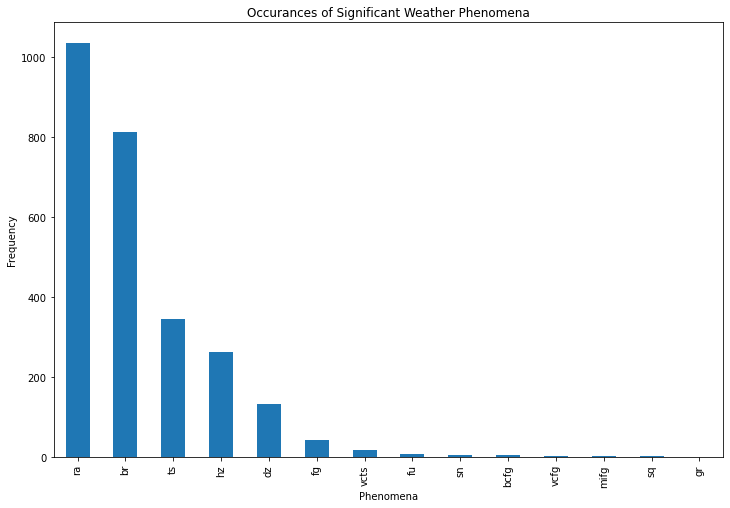

In [68]:
plt.figure(figsize = (12,8))
plt.title('Occurances of Significant Weather Phenomena')
plt.xlabel('Phenomena')
plt.ylabel('Frequency')
we_types.sum().sort_values(ascending = False).plot.bar();

In [69]:
we_types

,bcfg,br,dz,fg,fu,gr,hz,mifg,ra,sn,sq,ts,vcfg,vcts
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2940,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2941,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2942,0,0,0,0,0,0,0,0,1,1,0,0,0,0


In [70]:
weather.drop(columns = 'codesum', inplace = True)

In [71]:
weather_clean = pd.concat(
    objs = [weather, we_types],
    axis = 1
)

## Numericizing Columns

In [72]:
weather_clean.isin(['M','T']).sum()

station        0
date           0
tmax           0
tmin           0
tavg           0
depart         0
dewpoint       0
wetbulb        0
heat           0
cool           0
sunrise        0
sunset         0
preciptotal    0
stnpressure    0
sealevel       0
resultspeed    0
resultdir      0
avgspeed       0
day            0
month          0
year           0
sunrise_dur    0
sunset_dur     0
bcfg           0
br             0
dz             0
fg             0
fu             0
gr             0
hz             0
mifg           0
ra             0
sn             0
sq             0
ts             0
vcfg           0
vcts           0
dtype: int64

In [73]:
num_list = ['depart', 'wetbulb', 'preciptotal', 'stnpressure', 'sealevel', 'avgspeed']
for col in num_list:
    weather_clean[col].astype(float)

In [74]:
# check for missing or trace values based on data dict
weather.isin(['T', 'M']).sum()

station        0
date           0
tmax           0
tmin           0
tavg           0
depart         0
dewpoint       0
wetbulb        0
heat           0
cool           0
sunrise        0
sunset         0
preciptotal    0
stnpressure    0
sealevel       0
resultspeed    0
resultdir      0
avgspeed       0
day            0
month          0
year           0
sunrise_dur    0
sunset_dur     0
dtype: int64

# Exploratory Data Analysis

## Research

Based on this [CDC link](https://www.cdc.gov/dengue/resources/factsheets/mosquitolifecyclefinal.pdf), the entire lifecycle of a mosquito (from egg to adult) takes approximately 8-10 days.

This [link](https://www.preventivepestcontrol.com/weather-affect-mosquito-activity/) discusses about the type of weather favored by mosquitoes. Mosquitoes enjoy wet and warm climates and are most active in temperatures above 80 degrees. Conversely, when temperatures go below 50 degrees, mosquitoes go dormant.   

This [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3939474/) discusses the several symptoms (while extremely) of WNV. In general, 80% of persons infected with WNV remain asymptomatic. Of those who develop symptoms, the vast majority develop an acute, systemic febrile illness (“West Nile fever”, WNF). Data suggest that less than 1% of infected persons develop neurologic illness, which is primarily attributed to neuroinvasive disease. However, it is noted that the WNV continues to spread across US and will likely be a constant year-around presence. The need for effective vaccines and treatments is increasing in importance as this disease continues to expand its range and increase in severity.

In [75]:
# train has 2007, 2009, 2011, 2013 data
# test has 2008, 2010, 2012, 2014 data

In [76]:
# merge weather and train data first to do some EDA
# weather has 2007 to 2014
# spray only has 2011 and 2013

In [77]:
# combine df: can drop traps, addressaccuracy

In [78]:
# look as time series for weather 0 - 10 days before
    # if it rains 10 days, if temp is XX
        # how likely to get wnv
        
# time series matters for weather condition

In [81]:
combine = train_clean.merge(weather, on=['date', 'day', 'month', 'year'])

## Number of species

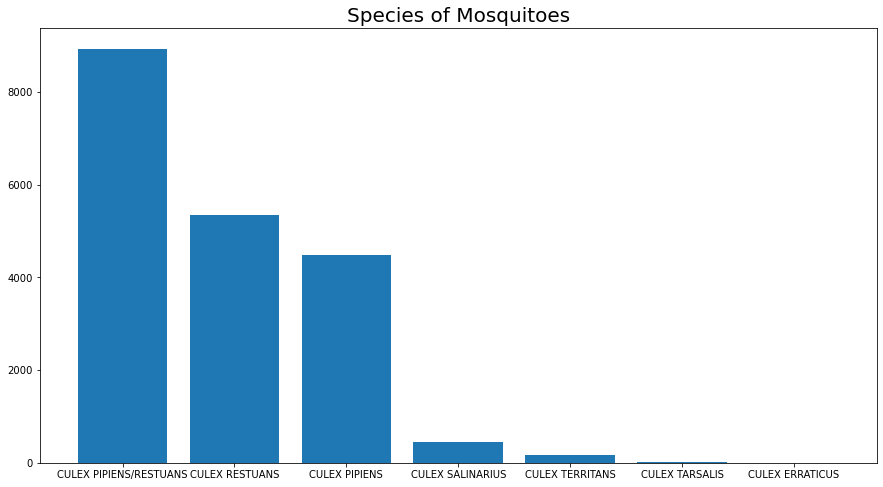

In [82]:
plt.figure(figsize=(15,8))
plt.bar(x=combine['species'].unique(), height=combine['species'].value_counts())

plt.title('Species of Mosquitoes', fontsize=20);

## Traps which recorded the most number of mosquitoes

In [83]:
combine.head()

,date,species,trap,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,day,month,year,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,sunrise_dur,sunset_dur
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,9,1,0,29,5,2007,1,88,60,74,10,58,65,0,9,421,1917,0.00,29.39,30.11,5.8,18,6.5,261,1157
1,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,9,1,0,29,5,2007,2,88,65,77,13,59,66,0,12,421,1917,0.00,29.44,30.09,5.8,16,7.4,261,1157
2,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,9,1,0,29,5,2007,1,88,60,74,10,58,65,0,9,421,1917,0.00,29.39,30.11,5.8,18,6.5,261,1157
3,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,9,1,0,29,5,2007,2,88,65,77,13,59,66,0,12,421,1917,0.00,29.44,30.09,5.8,16,7.4,261,1157
4,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,9,1,0,29,5,2007,1,88,60,74,10,58,65,0,9,421,1917,0.00,29.39,30.11,5.8,18,6.5,261,1157


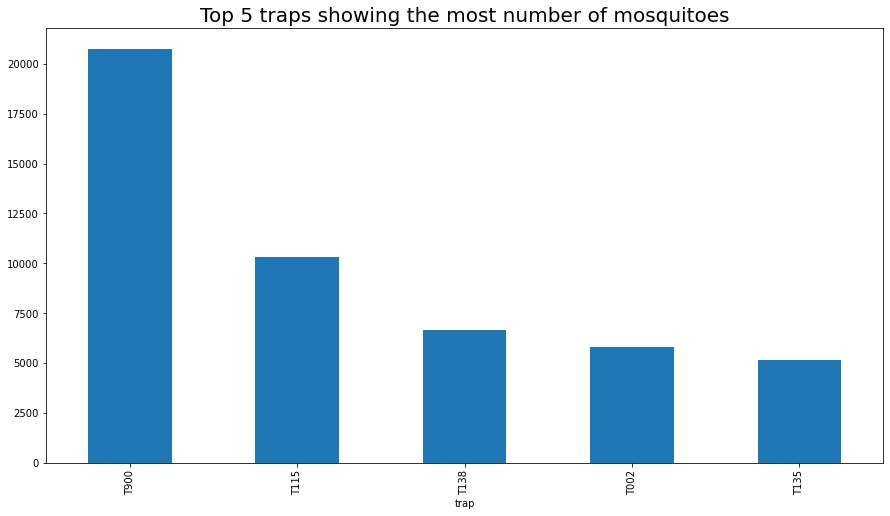

In [84]:
plt.figure(figsize=(15,8))
combine.groupby('trap')['nummosquitos'].sum().sort_values(ascending=False).head().plot(kind='bar')

plt.title('Top 5 traps showing the most number of mosquitoes', fontsize=20);


Let's have a look at where these traps are located at.

In [85]:
# looking at locations
combine.groupby(['latitude', 'longitude'])['nummosquitos'].sum().sort_values(ascending=False)

latitude   longitude 
41.974689  -87.890615    20768
41.673408  -87.599862    10336
41.726465  -87.585413     6662
41.954690  -87.800991     5788
41.662014  -87.724608     5144
42.008314  -87.777921     5074
41.704572  -87.565666     4430
41.682587  -87.707973     4158
41.680946  -87.535198     3916
41.916265  -87.800515     3786
41.743402  -87.731435     3728
41.798697  -87.736812     3722
41.957799  -87.930995     3650
41.867108  -87.654224     3592
41.702724  -87.536497     3390
41.868077  -87.666901     3264
41.899230  -87.716788     3200
41.801498  -87.763416     3086
41.659112  -87.538693     2720
41.771660  -87.703047     2712
41.964242  -87.757639     2690
41.992478  -87.862995     2654
41.678618  -87.559308     2632
41.944869  -87.832763     2622
41.732984  -87.649642     2552
41.923738  -87.785288     2386
41.688324  -87.676709     2334
41.720848  -87.666014     2294
41.740641  -87.546587     2226
41.728495  -87.600963     2162
41.973845  -87.805059     2162
41.778297  -87.75

We can narrow down and look at the areas where there are high records of mosquitoes based on the latitude and longitude data.

## Frequency of mosquitoes over the years

In [86]:
train_clean.head()

,date,species,trap,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,day,month,year
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,9,1,0,29,5,2007
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,9,1,0,29,5,2007
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,9,1,0,29,5,2007
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,8,1,0,29,5,2007
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,8,4,0,29,5,2007


## Frequency of mosquitoes over the years (by species)

In [87]:
combine.groupby(['year', 'species'])[['nummosquitos']].sum().reset_index()

,year,species,nummosquitos
0,2007,CULEX PIPIENS,29080
1,2007,CULEX PIPIENS/RESTUANS,30530
2,2007,CULEX RESTUANS,3270
3,2007,CULEX SALINARIUS,122
4,2007,CULEX TERRITANS,684
5,2009,CULEX PIPIENS,1704
6,2009,CULEX PIPIENS/RESTUANS,23110
7,2009,CULEX RESTUANS,8996
8,2009,CULEX SALINARIUS,52
9,2009,CULEX TARSALIS,4


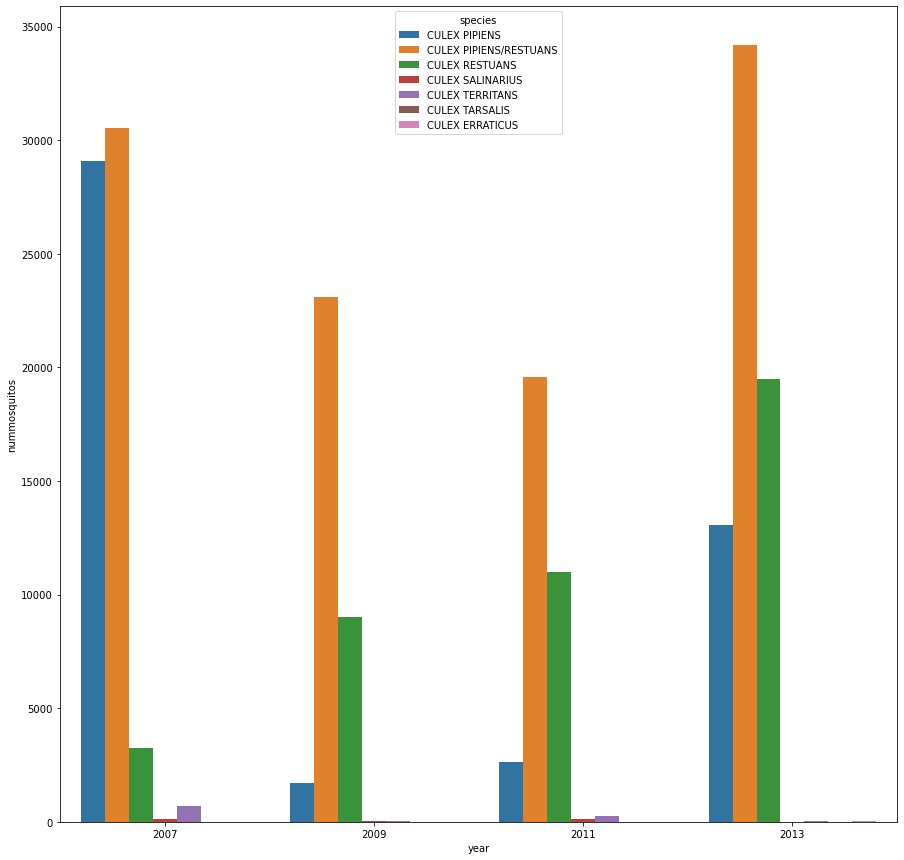

In [88]:
plt.figure(figsize=(15,15))
sns.barplot(data=combine.groupby(['year', 'species'])['nummosquitos'].sum().reset_index(),
            x='year',
            y='nummosquitos',
            hue='species');

## Frequency of mosquitoes for each day for each year

In [89]:
# finding out the number of mosquitoes by each day
train_clean.groupby(['date', 'species', 'trap', 'latitude', 'longitude', 
                     'addressaccuracy', 'wnvpresent', 'day', 'month', 'year']).sum().reset_index()

,date,species,trap,latitude,longitude,addressaccuracy,wnvpresent,day,month,year,nummosquitos
0,2007-05-29,CULEX PIPIENS,T096,41.731922,-87.677512,8,0,29,5,2007,1
1,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,9,0,29,5,2007,1
2,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,8,0,29,5,2007,1
3,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,8,0,29,5,2007,1
4,2007-05-29,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,8,0,29,5,2007,1
...,...,...,...,...,...,...,...,...,...,...,...
8605,2013-09-26,CULEX RESTUANS,T082,41.803423,-87.642984,8,0,26,9,2013,2
8606,2013-09-26,CULEX RESTUANS,T102,41.750498,-87.605294,5,0,26,9,2013,1
8607,2013-09-26,CULEX RESTUANS,T209,41.740641,-87.546587,5,0,26,9,2013,1
8608,2013-09-26,CULEX RESTUANS,T220,41.963976,-87.691810,9,0,26,9,2013,8


In [90]:
# train_clean.loc[train_clean['date'] == '2007-05-29', 'nummosquitos'].sum()
# checked that code correctly counts 

In [91]:
train_clean.groupby('date')['nummosquitos'].sum()

date
2007-05-29      40
2007-06-05     127
2007-06-26     215
2007-06-29      85
2007-07-02     240
2007-07-11     953
2007-07-18     752
2007-07-19     387
2007-07-25     719
2007-07-27     247
2007-08-01    3800
2007-08-02    1742
2007-08-03     104
2007-08-07    1780
2007-08-08    1086
2007-08-09     457
2007-08-15    4217
2007-08-16     655
2007-08-17    1274
2007-08-21    1666
2007-08-22    1612
2007-08-24    1477
2007-08-28    1355
2007-09-04     524
2007-09-05     520
2007-09-06     561
2007-09-12     993
2007-09-18     392
2007-09-19     654
2007-09-24    1170
2007-09-25     333
2007-10-04    1373
2007-10-09     333
2009-05-28     187
2009-06-02     613
2009-06-03     298
2009-06-05     257
2009-06-12    1204
2009-06-15     345
2009-06-19     701
2009-06-22     348
2009-06-26     748
2009-06-29     200
2009-07-06     715
2009-07-10     946
2009-07-13     856
2009-07-17    1790
2009-07-24    1065
2009-07-27    1081
2009-07-31    1001
2009-08-07     878
2009-08-13     601
2009-08

In [93]:
# set date as index and sort it
train_clean_timeindex = train_clean.set_index('date').sort_index()

In [94]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

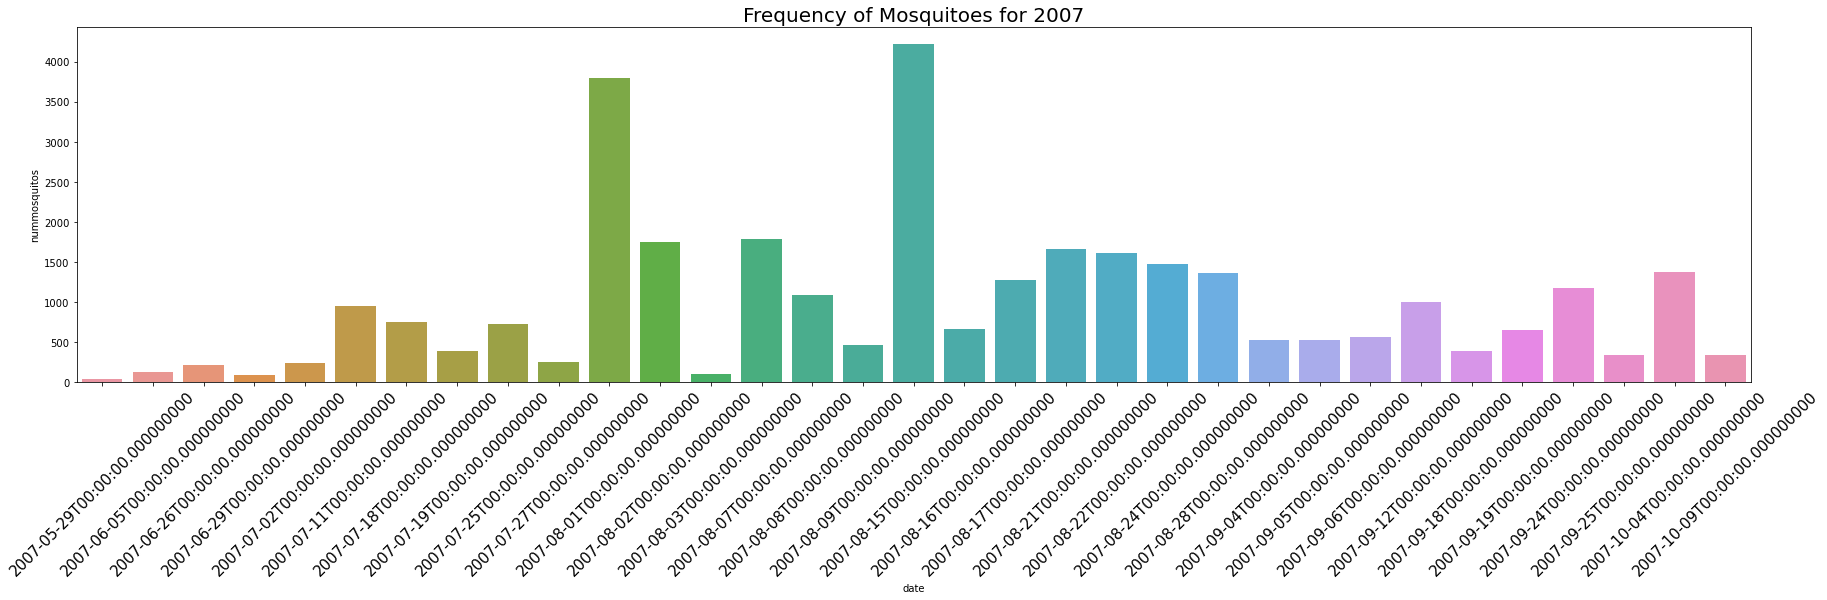

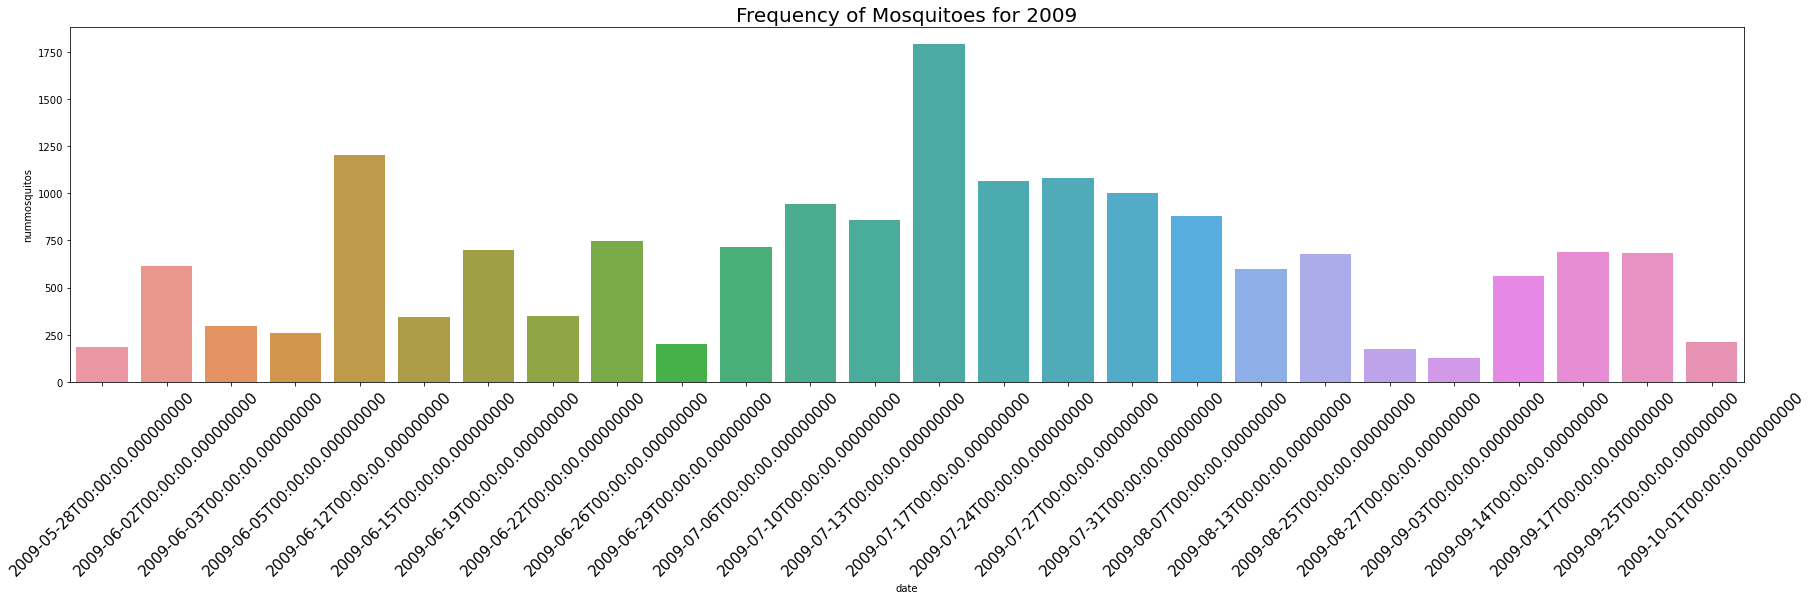

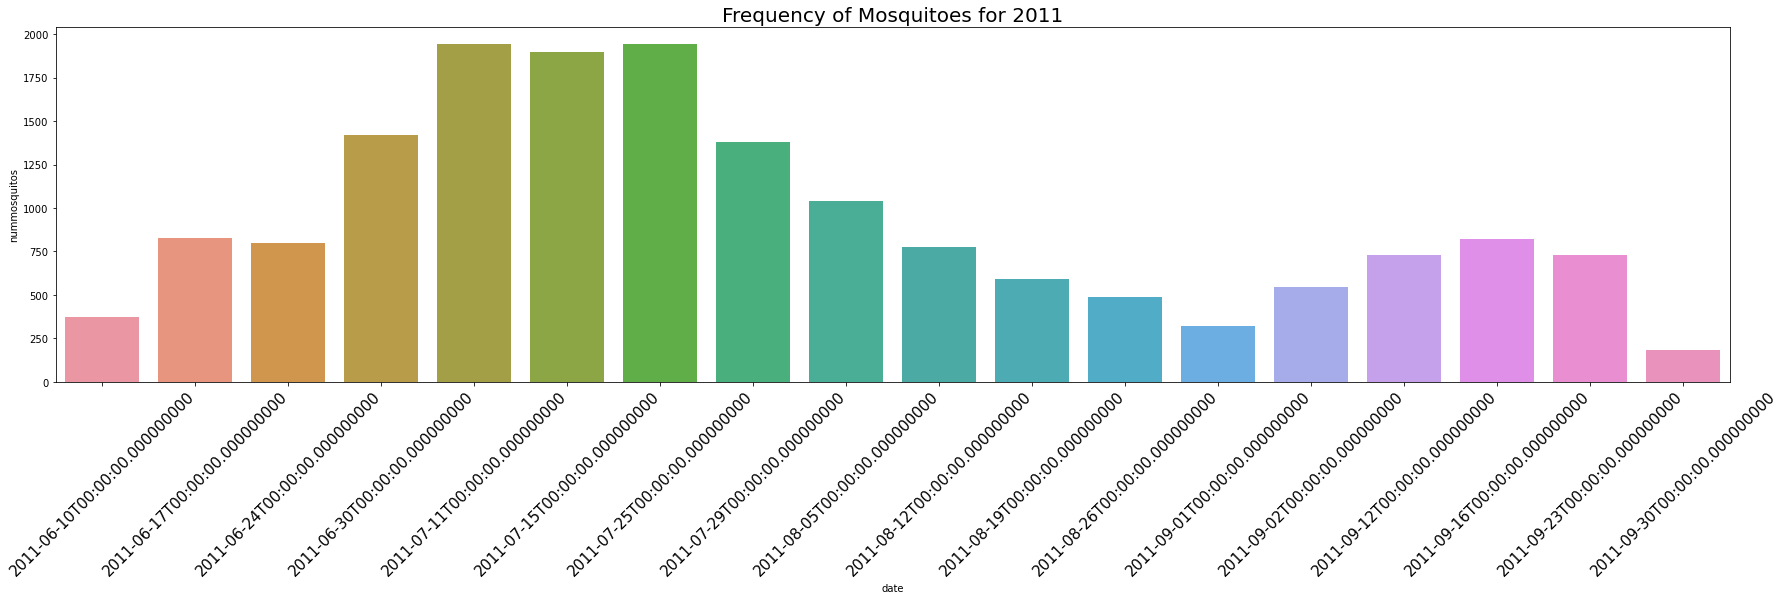

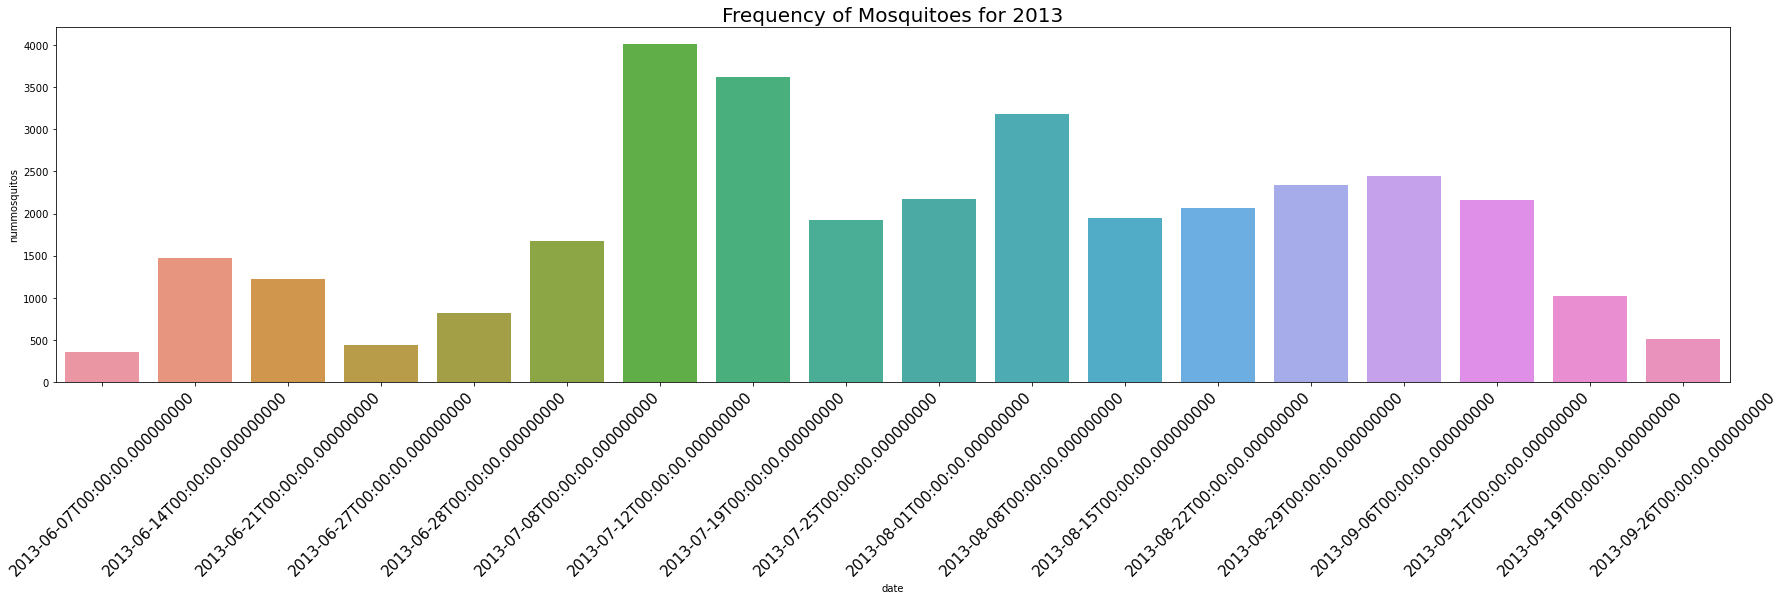

In [96]:
# did a loop to plot daily mosquito frequency for all years in train_clean
# unable to resolve xtick labels

dates = ['2007', '2009', '2011', '2013']

for i in range(len(dates)):
    plt.figure(figsize=(30,30))
    plt.subplot(4, 1, i+1)
    sns.barplot(data=train_clean_timeindex.loc[dates[i]].groupby('date')['nummosquitos'].sum().reset_index(),
                x='date',
                y='nummosquitos')

    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    #ax.bar(train_clean_timeindex[dates[i]], train_clean_timeindex[dates[i]]['nummosquitos'])


    plt.title(f'Frequency of Mosquitoes for {dates[i]}', fontsize=20)
    plt.xticks(rotation=45, fontsize=15);

## Correlation Matrix

In [97]:
combine['total_sunlight_mins'] = combine['sunset_dur'] - combine['sunrise_dur']

In [98]:
combine.drop(columns=['sunrise_dur', 'sunset_dur'], inplace=True)

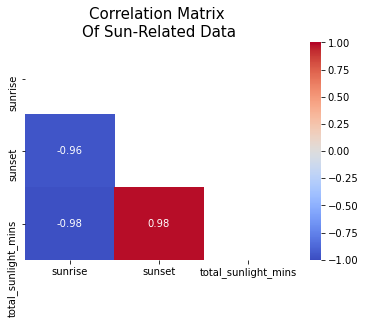

In [99]:
sun_data = combine[['sunrise', 'sunset', 'total_sunlight_mins']]
plt.figure()
matrix = np.triu(sun_data.corr())

sns.heatmap(sun_data.corr(), annot=True, cmap='coolwarm', mask=matrix, vmin=-1, vmax=1);

plt.title('Correlation Matrix \nOf Sun-Related Data', size = 15);

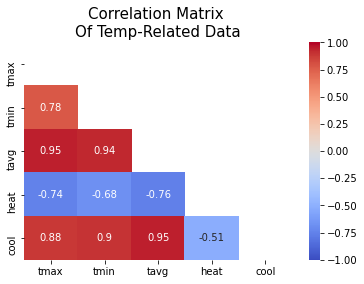

In [100]:
temp_data = combine[['tmax', 'tmin', 'tavg', 'heat', 'cool']]
plt.figure()
matrix = np.triu(temp_data.corr())

sns.heatmap(temp_data.corr(), annot=True, cmap='coolwarm', mask=matrix, vmin=-1, vmax=1);

plt.title('Correlation Matrix \nOf Temp-Related Data', size = 15);

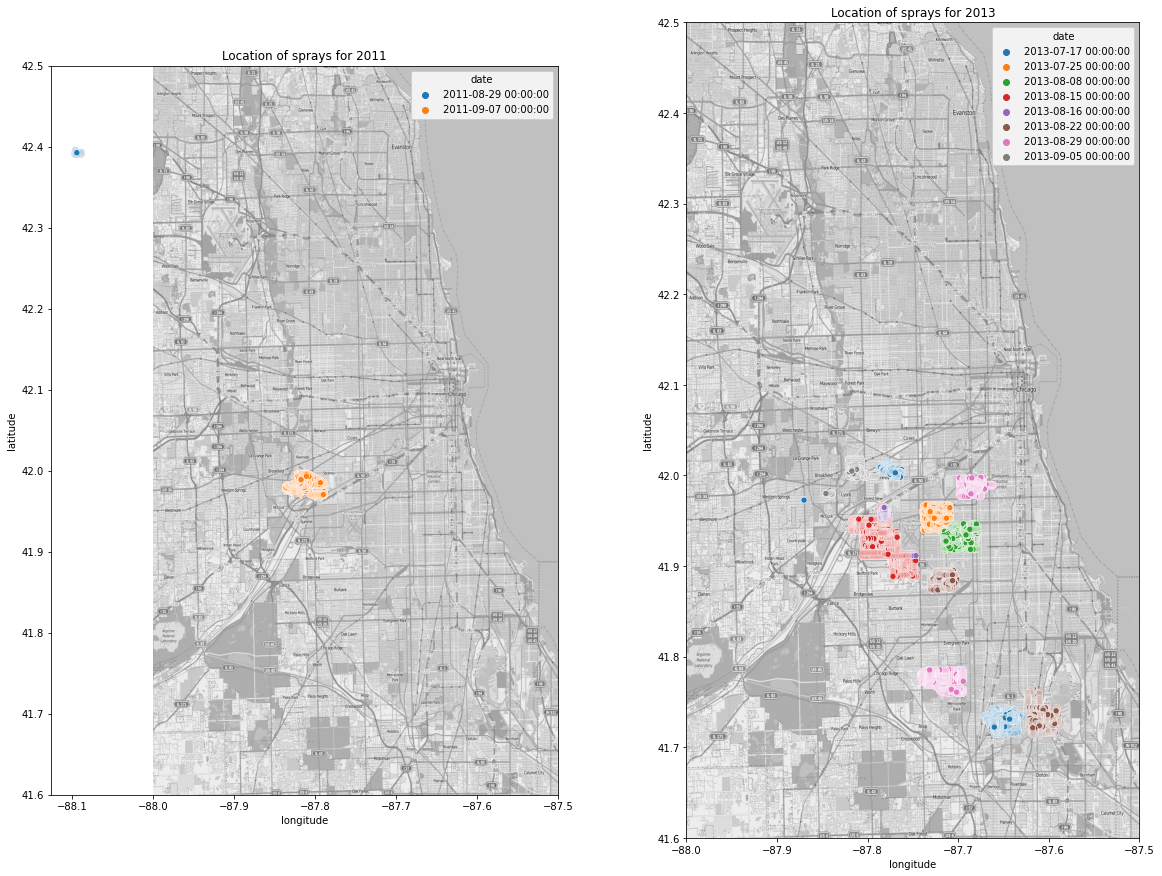

In [102]:
# location of sprays
mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")

origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
upperRight = [42.5, -87.5]          # lat/long of upper right corner

fig, ax = plt.subplots(1, 2, figsize = (20,15))
ax[0].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
ax[1].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])

sns.scatterplot(data=spray[spray['year'] == 2011], x='longitude', y='latitude', hue='date', ax=ax[0])
sns.scatterplot(data=spray[spray['year'] == 2013], x='longitude', y='latitude', hue='date', ax=ax[1])

ax[0].set_title('Location of sprays for 2011')
ax[1].set_title('Location of sprays for 2013');

In [103]:
# spray effectiveness?

## Feature Engineering

# Modelling

# Conclusion